In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Importing

In [2]:
data = pd.read_csv('ODI-2019-processed.csv')

In [3]:
# Make non-numerical inputs numerical
mapping = {
    np.nan:['unknown'],
    int(1):['yes','mu','ja','male','1'],
    int(0):['no','sigma','nee','female', '0']}

for key in mapping:
    data[data.columns[[1,2,3,4,5]]] = data[data.columns[[1,2,3,4,5]]].replace(to_replace = mapping[key], value = key)

In [5]:
test_data = data[data.columns[[1,2,3,4,5,9]]].copy().dropna()

for column in test_data.columns.values[:-1]:
    test_data[column] = test_data[column].astype(int)

In [9]:
# Reduce label length
old_labels = list(test_data.columns.values)
new_labels = ['ML', 'IR', 'ST', 'DB', 'gender', 'programme']
mapping = dict( zip(old_labels,new_labels) )
test_data = test_data.rename(mapping, axis='columns')

labels = test_data['programme'].unique().tolist()
mapping = dict( zip(labels,range(len(labels))) )
test_data.replace({'programme': mapping},inplace=True)

# 1. Pairplots

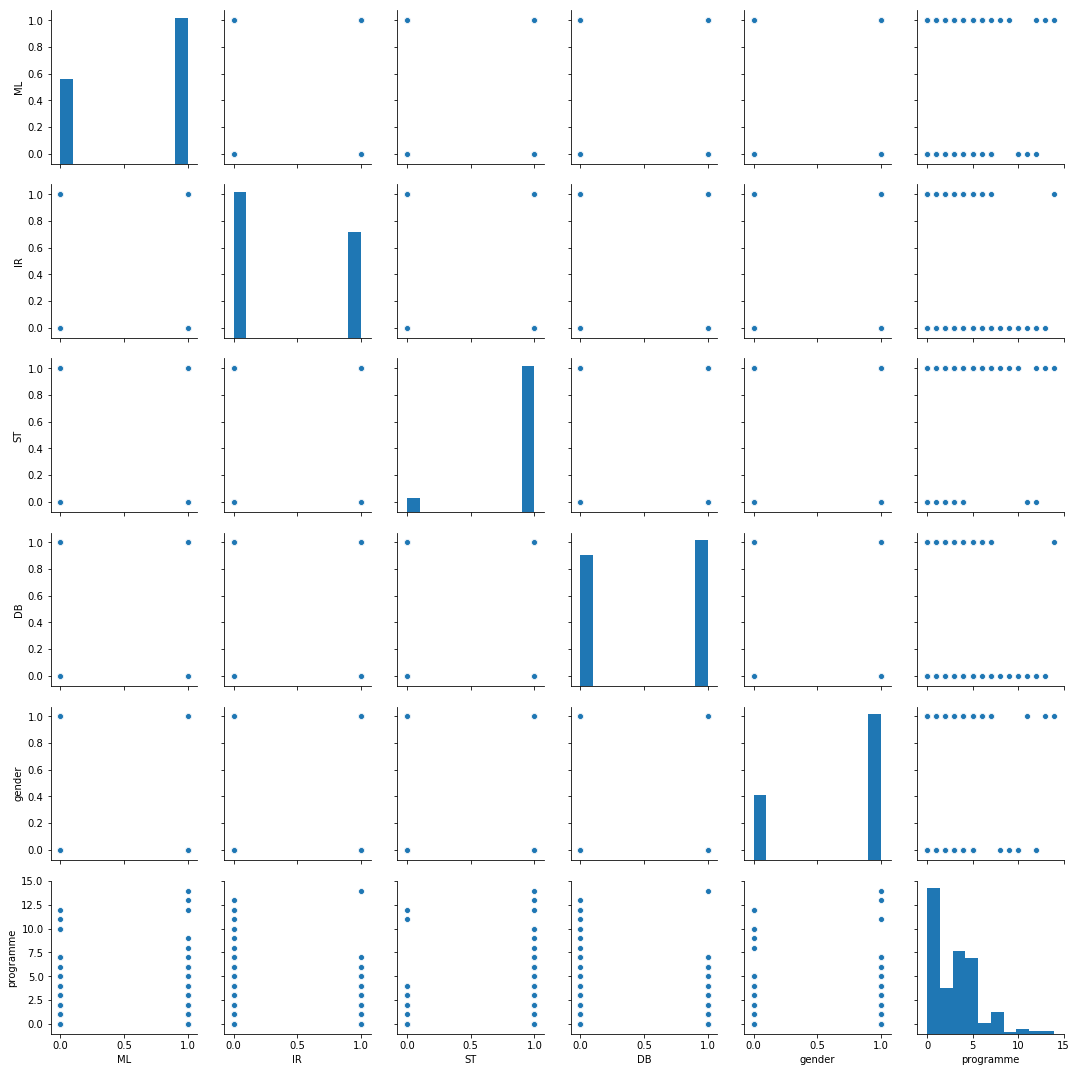

In [13]:
sns.pairplot(test_data).savefig("results/pairplot.png")

# 2. Correlation

In [14]:
corr = test_data.corr()
corr

,ML,IR,ST,DB,gender,programme
ML,1.000000,0.330050,0.067936,0.341862,0.065827,-0.072017
IR,0.330050,1.000000,0.023958,0.366246,0.076187,-0.299178
ST,0.067936,0.023958,1.000000,-0.055230,0.016617,0.013186
DB,0.341862,0.366246,-0.055230,1.000000,0.080808,-0.075084
gender,0.065827,0.076187,0.016617,0.080808,1.000000,0.036481
programme,-0.072017,-0.299178,0.013186,-0.075084,0.036481,1.000000


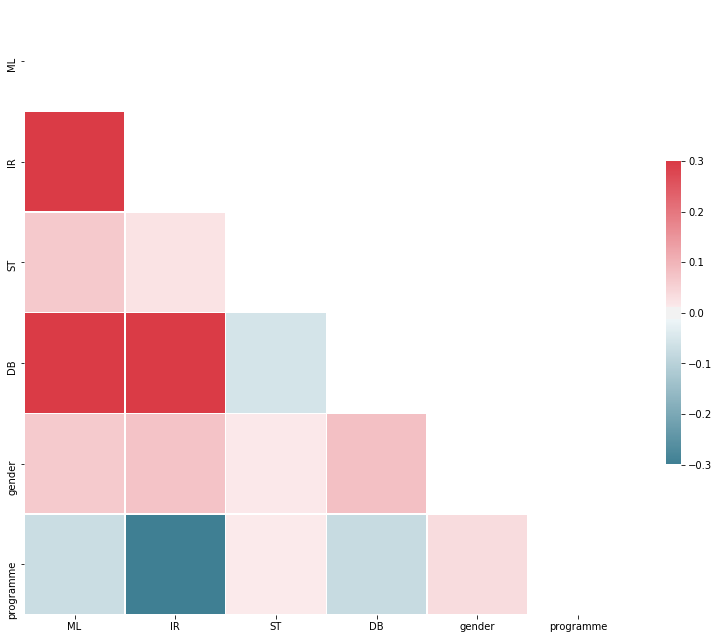

In [17]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.tight_layout()

f.savefig("results/part_correlation.png")

# 3. Regression

In [67]:
def kfoldlearning(X,y,prediction_column, regression, folds = 10):
    # scikit-learn k-fold cross-validation
    from sklearn.model_selection import KFold
    performances = []

    # prepare cross validation
    kfold = KFold(folds, True)
    # enumerate splits
    for train_index, test_index in kfold.split(X, y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if regression == "linear":
            X_test_data = linregression(X_train, X_test, y_train, y_test)
        elif regression == "bayes":
            X_test_data = bayes(X_train, X_test, y_train, y_test)
        elif regression == "decision_tree":
            X_test_data = decision_tree(X_train, X_test, y_train, y_test)
        else:
            print("model not found")
            return
            
        count = testregression(X_test_data, test_data, prediction_column)
        print(str(count) + " correct out of " + str(len(X_test_data)))
        performances.append(count/len(X_test_data))
        
    print("\nhighest accuracy:\t" + str((np.max(performances)*100).round(1)) + "% accuracy"
         + "\nlowest accuracy:\t" + str((np.min(performances)*100).round(1)) + "% accuarcy"
         + "\nmean accuracy:\t\t"   + str((np.mean(performances)*100).round(1)) + "% accuracy")

In [50]:
def testregression(X_test_data, test_data, prediction_column):
    count = 0
    for x in range(len(test_data)):
        try:
            if X_test_data.loc[x]['predictions']==test_data.loc[x][prediction_column]:
                count += 1
        except:
            pass

    return count

## 3.1 Linear Regression

In [63]:
from sklearn.linear_model import LinearRegression
def linregression(X_train, X_test, y_train, y_test):
    lm = LinearRegression()
    lm.fit(X_train,y_train)

    X_test_data = X_test.copy()
    X_test_data['predictions'] = lm.predict(X_test).round().astype(int)
    
    return X_test_data

In [68]:
# Predict programme based on ML, IR, ST and DB
X = test_data[test_data.columns[[0,1,2,3,4]]]
y = test_data[test_data.columns[5]]
kfoldlearning(X,y,'programme', 'linear')

2 correct out of 25
2 correct out of 25
3 correct out of 25
2 correct out of 25
2 correct out of 25
2 correct out of 25
4 correct out of 25
5 correct out of 25
3 correct out of 25
2 correct out of 25

highest accuracy:	20.0% accuracy
lowest accuracy:	8.0% accuarcy
mean accuracy:		10.8% accuracy


In [69]:
# Predict ML on IR, ST and DB
X = test_data[test_data.columns[[1,2,3,4]]]
y = test_data[test_data.columns[0]]
kfoldlearning(X,y,'ML','linear')

17 correct out of 25
13 correct out of 25
17 correct out of 25
15 correct out of 25
17 correct out of 25
17 correct out of 25
17 correct out of 25
18 correct out of 25
19 correct out of 25
15 correct out of 25

highest accuracy:	76.0% accuracy
lowest accuracy:	52.0% accuarcy
mean accuracy:		66.0% accuracy


## 3.2 Naive Bayes

In [70]:
from sklearn.naive_bayes import GaussianNB

def bayes(X_train, X_test, y_train, y_test):
    gaussian = GaussianNB()
    gaussian.fit(X_train,y_train)

    X_test_data = X_test.copy()

    X_test_data['predictions'] = gaussian.predict(X_test).round().astype(int)
    
    return X_test_data

In [71]:
# Predict programme based on ML, IR, ST and DB
X = test_data[test_data.columns[[0,1,2,3,4]]]
y = test_data[test_data.columns[5]]
kfoldlearning(X,y,'programme','bayes')

4 correct out of 25
4 correct out of 25
3 correct out of 25
2 correct out of 25
4 correct out of 25
3 correct out of 25
3 correct out of 25
3 correct out of 25
3 correct out of 25
3 correct out of 25

highest accuracy:	16.0% accuracy
lowest accuracy:	8.0% accuarcy
mean accuracy:		12.8% accuracy


In [72]:
# Predict ML on IR, ST and DB
X = test_data[test_data.columns[[1,2,3,4]]]
y = test_data[test_data.columns[0]]
kfoldlearning(X,y,'ML','bayes')

18 correct out of 25
15 correct out of 25
12 correct out of 25
16 correct out of 25
18 correct out of 25
16 correct out of 25
16 correct out of 25
16 correct out of 25
19 correct out of 25
18 correct out of 25

highest accuracy:	76.0% accuracy
lowest accuracy:	48.0% accuarcy
mean accuracy:		65.6% accuracy


## 3.3 Decision Tree

In [73]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(X_train, X_test, y_train, y_test):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train,y_train)

    X_test_data = X_test.copy()

    X_test_data['predictions'] = decision_tree.predict(X_test).round().astype(int)
    
    return X_test_data

In [74]:
# Predict programme based on ML, IR, ST and DB
X = test_data[test_data.columns[[0,1,2,3,4]]]
y = test_data[test_data.columns[5]]
kfoldlearning(X,y,'programme','decision_tree')

6 correct out of 25
6 correct out of 25
8 correct out of 25
16 correct out of 25
10 correct out of 25
6 correct out of 25
8 correct out of 25
7 correct out of 25
5 correct out of 25
13 correct out of 25

highest accuracy:	64.0% accuracy
lowest accuracy:	20.0% accuarcy
mean accuracy:		34.0% accuracy


In [75]:
# Predict ML on IR, ST and DB
X = test_data[test_data.columns[[1,2,3,4]]]
y = test_data[test_data.columns[0]]
kfoldlearning(X,y,'ML','decision_tree')

11 correct out of 25
15 correct out of 25
15 correct out of 25
17 correct out of 25
14 correct out of 25
21 correct out of 25
18 correct out of 25
12 correct out of 25
18 correct out of 25
17 correct out of 25

highest accuracy:	84.0% accuracy
lowest accuracy:	44.0% accuarcy
mean accuracy:		63.2% accuracy
